# Model Selection

The following scripts analyses the performance of different models on a given dataset. 

## Initialisation

In [14]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Users\dawson\Documents\GitHub\ode-biomarker-project


In [15]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [16]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [17]:
from toolkit import *

In [18]:
folder_name = "ModelSelectionFGFR4"
exp_id = "test"
fixed_random_seed = 42 # -1 for no seed
save_figure = False
save_data = True
show_figure = False

all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

## Analysis 1 

In [19]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

In [20]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    k = X_train.shape[1]
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [21]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [22]:
for model_used in all_models: 
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_simple.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Loading Results from Analysis 1

In [23]:
import pickle 

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_simple.pkl')
    df_list.append(df)


In [24]:
df_list[4]

,rng,condition,model_performance,p_vals
0,0,KNeighborsRegressor,0.157583,0.202814
1,1,KNeighborsRegressor,0.386604,0.001231
2,2,KNeighborsRegressor,0.133297,0.282216
3,3,KNeighborsRegressor,0.234929,0.055663
4,4,KNeighborsRegressor,0.021976,0.859888
...,...,...,...,...
95,95,KNeighborsRegressor,0.225296,0.066792
96,96,KNeighborsRegressor,0.336693,0.005337
97,97,KNeighborsRegressor,0.054683,0.660295
98,98,KNeighborsRegressor,0.189790,0.123980


In [25]:
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

,rng,condition,model_performance,p_vals
0,0,SVR,0.128484,0.300110
1,1,SVR,0.173691,0.159821
2,2,SVR,-0.092274,0.457682
3,3,SVR,0.060600,0.626157
4,4,SVR,0.031569,0.799801


<AxesSubplot: title={'center': 'Model Performance'}, xlabel='Model', ylabel='Pearson Correlation'>

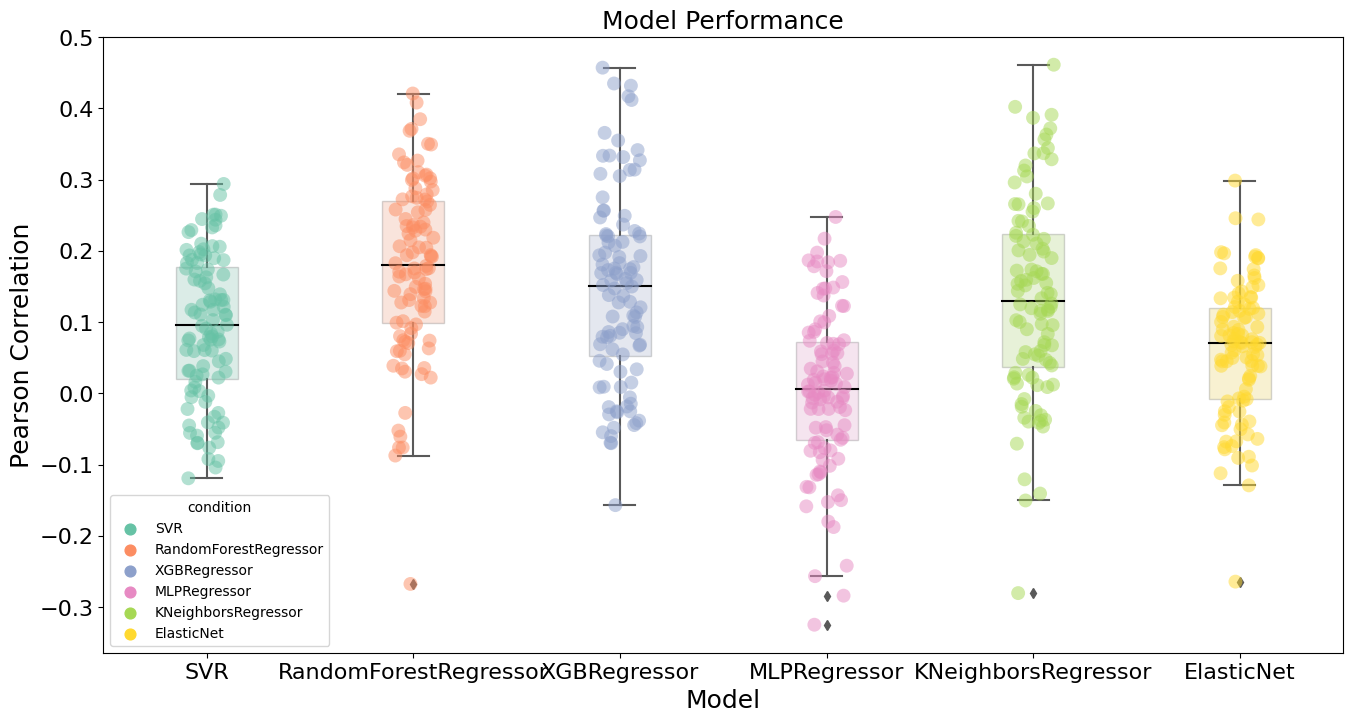

In [26]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


## Analysis 2 - Simple Feature Selection

To observe the effect of feature size on model performance, simple f-regression is used as a filtering step to allow only half of the features to pass through.

In [27]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

In [28]:
def pipeline_func(X_train, y_train, rng, model_used, **kwargs):
    k = X_train.shape[1]
    selected_features, scores = f_regression_select(X_train, y_train, int(k/2))
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [29]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used}, eval_func, {})

In [30]:
for model_used in all_models: 
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_2.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Results from Analysis 2

In [31]:
import pickle

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_simple.pkl')
    df_list.append(df)
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

,rng,condition,model_performance,p_vals
0,0,SVR,0.128484,0.300110
1,1,SVR,0.173691,0.159821
2,2,SVR,-0.092274,0.457682
3,3,SVR,0.060600,0.626157
4,4,SVR,0.031569,0.799801


<AxesSubplot: title={'center': 'Model Performance With Simple Feature Selection'}, xlabel='Model', ylabel='Pearson Correlation'>

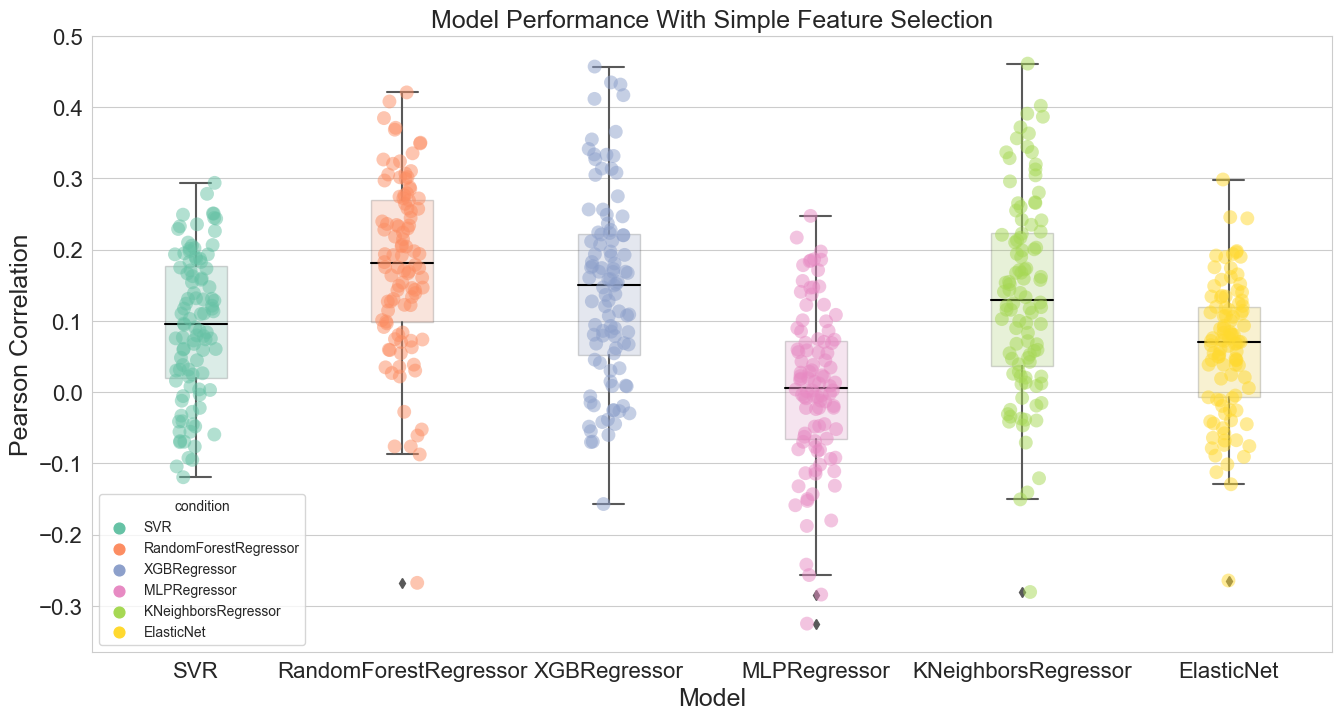

In [32]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance With Simple Feature Selection', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


## Analysis 3 - Ensemble Feature Selection 

In [ ]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

all_methods = [f_regression_select, pearson_corr_select, mutual_information_select, relieff_select, rf_select]
all_kwargs = [{}, {'return_all': False}, {}, {}, {'random_state': 42}]
all_ways = ['one_way', 'two_way', 'one_way', 'one_way', 'one_way']
# features, scores = ensemble_percentile_threshold(feature_data, label_data, -1, all_methods, all_kwargs, all_ways)

In [ ]:
pipeline_args = {'all_methods': all_methods, 'all_kwargs': all_kwargs, 'all_ways': all_ways}

def ensemble_pipeline_func(X_train, y_train, rng, model_used, all_methods, all_kwargs, all_ways, **kwargs):
    selected_features, scores = ensemble_percentile_threshold(X_train, y_train, -1, all_methods, all_kwargs, all_ways, n_jobs=4)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [ ]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used}, eval_func, {})

In [ ]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 4, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')

## Analysis 3 - A more efficient implementation

Processes can be made more efficient by pre-computing the ensemble feature selection step. The pre-computed ensemble features from different spliting seeds can then be applied to each model.

Subsequently, the rng seed can be matched later in the training process

### Initial Setup

In [33]:
# runs feature selection 

powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))
# lite version 
all_methods = [f_regression_select, pearson_corr_select, mutual_information_select]
all_kwargs = [{}, {'return_all': False}, {}]
all_ways = ['one_way', 'two_way', 'one_way']

### Feature Selection Step

In [34]:
# import train_test_split
from sklearn.model_selection import train_test_split # type: ignore
import pickle 

feature_selection_data = {}

for i, rng in enumerate(rngs):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, label_data, test_size=0.1, random_state=rng)
    try: 
        selected_features, scores = ensemble_percentile_threshold(X_train, y_train, -1, all_methods, all_kwargs, all_ways, n_jobs=-1)
        print(f'Finished {i+1} of {len(rngs)}')
        feature_selection_data[rng] = (selected_features, scores)
    except Exception as e:
        print(f'Failed {i+1} of {len(rngs)} with error: {e}')
        continue
    
with open(f'{file_save_path}{exp_id}_ensemble_feature_selection_split_data_100.pkl', 'wb') as f:
    pickle.dump(feature_selection_data, f)
    


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 1 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 2 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 3 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 4 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 5 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 6 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 7 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 8 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 9 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 ou

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 10 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 11 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 12 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 13 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 14 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 15 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 16 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 17 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 18 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 19 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 20 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 21 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 22 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 23 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 24 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 25 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 26 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 27 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 28 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 29 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 30 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 31 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 32 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 33 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 34 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 35 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 36 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 37 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 38 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 39 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 40 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 41 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 42 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 43 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 44 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 45 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 46 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 47 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 48 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 49 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 50 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 51 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 52 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 53 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 54 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 55 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 56 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 57 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 58 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 59 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 60 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 61 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 62 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 63 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 64 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 65 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 66 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 67 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 68 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 69 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 70 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 71 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 72 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 73 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 74 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 75 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 76 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 77 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 78 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 79 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 80 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 81 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 82 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 83 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 84 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 85 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 86 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 87 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 88 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 89 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 90 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 91 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 92 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 93 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 94 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 95 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 96 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 97 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 98 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 99 of 100
Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 o

invalid value encountered in sqrt


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks
Finished 100 of 100


### Model Training Step 

In [35]:
import pickle

# load in the feature selection data
with open(f'{file_save_path}{exp_id}_ensemble_feature_selection_split_data_100.pkl', 'rb') as f:
    feature_selection_data = pickle.load(f)
    
print(f'Size of feature selection data: {len(feature_selection_data)}')

Size of feature selection data: 100


In [36]:
pipeline_args = {'model_used': model_used, 'feature_selection_data': feature_selection_data}

def ensemble_pipeline_func_pre_compute(X_train, y_train, rng, model_used, feature_selection_data, **kwargs):
    if rng in feature_selection_data:
        selected_features, scores = feature_selection_data[rng]
    else: 
        return {'model': None}
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}
    
def eval_func_pre_compute(X_test, y_test, pipeline_components=None, **kwargs):
    if pipeline_components['model'] is None:
        return {'model_performance': 0, 'p_vals': 0, 'feature_importance': 0}
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}

In [37]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, ensemble_pipeline_func_pre_compute, pipeline_args, eval_func_pre_compute, {})

In [38]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, 16, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')

Running SVR...
Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


### Results

In [39]:
import pickle

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_ensemble.pkl')
    df_list.append(df)

In [40]:
df_all = pd.concat(df_list, axis=0)
df_all.head()

,rng,condition,model_performance,p_vals,feature_importance
0,0,SVR,0.152487,0.217989,"([amTORC2_tfc, aGAB1_max, aGAB1_tsv, aGAB1_med..."
1,1,SVR,0.135642,0.273759,"([amTORC2_tfc, FOXO_tmin, FOXO_tmax, pFRS2_tsv..."
2,2,SVR,0.093774,0.450373,"([aShp2_max, aShp2_tsv, aShp2_auc, aShp2_media..."
3,3,SVR,-0.032060,0.796755,"([aGAB1_max, aGAB1_tsv, aShp2_min, aGAB1_media..."
4,4,SVR,-0.287295,0.018409,"([aShp2_max, aShp2_tsv, amTORC2_tfc, aShp2_med..."


<AxesSubplot: title={'center': 'Model Performance With Ensemble Feature Selection'}, xlabel='Model', ylabel='Pearson Correlation'>

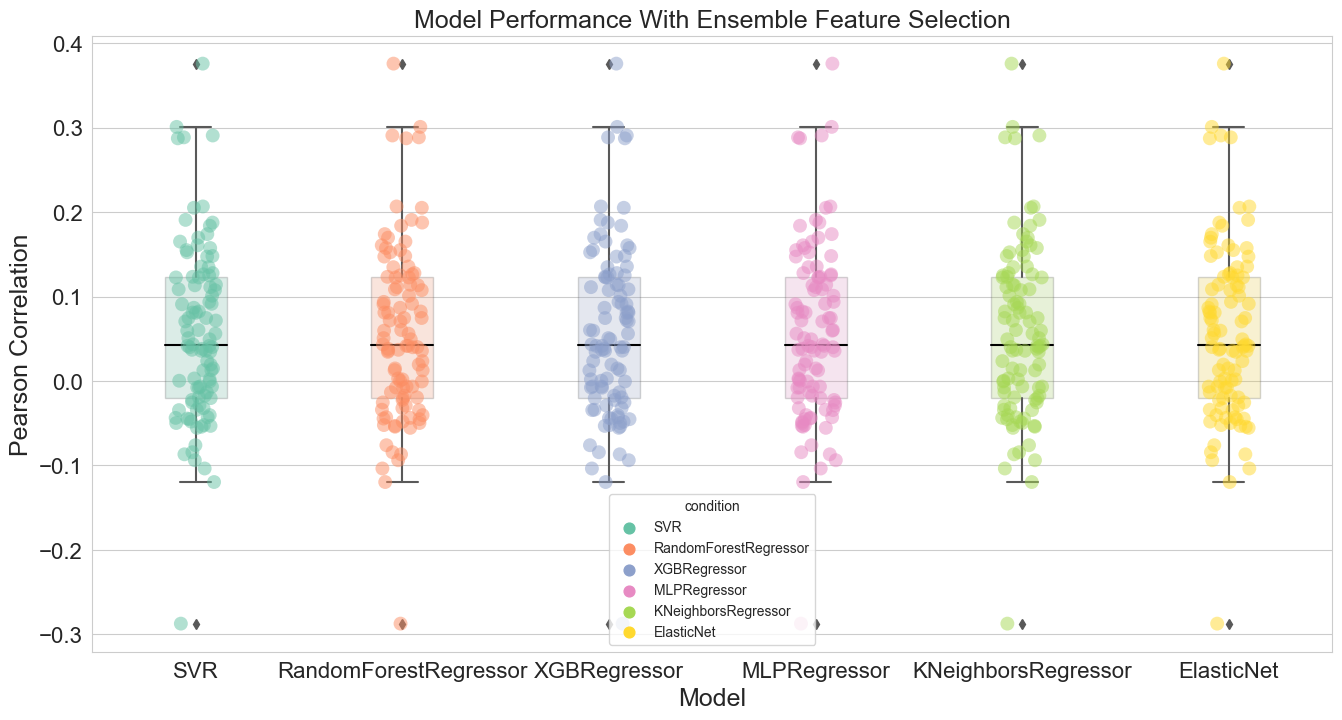

In [41]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance With Ensemble Feature Selection', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)
